## Importing libraries and loading data

In [7]:
import os
import numpy as np
import tensorflow as tf
from keras import layers, models
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt


tf.random.set_seed(42)


DATA_DIR = 'farm_insects'
image_size = 64
batch_size = 256

# Prepare data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    image_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True
)


from keras.layers import Rescaling


normalization_layer = Rescaling(scale=1./127.5, offset=-1)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))



Found 1591 files belonging to 15 classes.


In [8]:

discriminator = models.Sequential([
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=[image_size, image_size, 3]),
    layers.LeakyReLU(0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(0.2),
    layers.Conv2D(1, kernel_size=4, strides=1, padding="valid"),
    layers.Flatten(),
    layers.Activation('sigmoid')
])


latent_size = 128
generator = models.Sequential([
    layers.Input(shape=(latent_size,)),
    layers.Dense(4 * 4 * 512),
    layers.Reshape((4, 4, 512)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same"),
    layers.Activation('tanh')
])


In [14]:

loss_fn = tf.keras.losses.BinaryCrossentropy()


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

@tf.function
def train_step(real_images):
    noise = tf.random.normal([batch_size, latent_size])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        
        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss_real = loss_fn(tf.ones_like(real_output), real_output)
        disc_loss_fake = loss_fn(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss


In [15]:
epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for images, _ in tqdm(train_ds):
        gen_loss, disc_loss = train_step(images)
        
    print(f"Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

Epoch 1/1000


100%|██████████| 7/7 [00:17<00:00,  2.45s/it]


Generator Loss: 2.9337141513824463, Discriminator Loss: 0.24630135297775269
Epoch 2/1000


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Generator Loss: 0.9079787135124207, Discriminator Loss: 0.9217623472213745
Epoch 3/1000


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Generator Loss: 6.900018692016602, Discriminator Loss: 1.2960219383239746
Epoch 4/1000


100%|██████████| 7/7 [00:14<00:00,  2.14s/it]


Generator Loss: 2.5199012756347656, Discriminator Loss: 0.2972145974636078
Epoch 5/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 2.6040189266204834, Discriminator Loss: 0.2113603949546814
Epoch 6/1000


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Generator Loss: 4.204782962799072, Discriminator Loss: 0.33281591534614563
Epoch 7/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 3.871839761734009, Discriminator Loss: 0.3566148281097412
Epoch 8/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 1.5764862298965454, Discriminator Loss: 0.7721654176712036
Epoch 9/1000


100%|██████████| 7/7 [00:15<00:00,  2.24s/it]


Generator Loss: 2.2930665016174316, Discriminator Loss: 0.31326907873153687
Epoch 10/1000


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Generator Loss: 3.841151237487793, Discriminator Loss: 0.15257295966148376
Epoch 11/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 2.3449559211730957, Discriminator Loss: 0.3066178560256958
Epoch 12/1000


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Generator Loss: 3.8012938499450684, Discriminator Loss: 0.11024509370326996
Epoch 13/1000


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Generator Loss: 1.4077332019805908, Discriminator Loss: 0.6687902212142944
Epoch 14/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 2.379875421524048, Discriminator Loss: 0.3717113137245178
Epoch 15/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 1.3494417667388916, Discriminator Loss: 0.6161370277404785
Epoch 16/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 4.3685150146484375, Discriminator Loss: 0.17749449610710144
Epoch 17/1000


100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


Generator Loss: 5.820932865142822, Discriminator Loss: 0.13965874910354614
Epoch 18/1000


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Generator Loss: 3.821889877319336, Discriminator Loss: 0.12449359893798828
Epoch 19/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 2.925835609436035, Discriminator Loss: 0.2386283278465271
Epoch 20/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 4.55748987197876, Discriminator Loss: 0.16779790818691254
Epoch 21/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 7.774738788604736, Discriminator Loss: 0.2464928925037384
Epoch 22/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 3.0680623054504395, Discriminator Loss: 0.23243525624275208
Epoch 23/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 3.227548599243164, Discriminator Loss: 0.42774534225463867
Epoch 24/1000


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Generator Loss: 3.017212152481079, Discriminator Loss: 0.30546435713768005
Epoch 25/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 3.427858352661133, Discriminator Loss: 0.3654255270957947
Epoch 26/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 2.543541669845581, Discriminator Loss: 0.32834142446517944
Epoch 27/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 2.570472240447998, Discriminator Loss: 0.18106985092163086
Epoch 28/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 2.438049554824829, Discriminator Loss: 0.5170552730560303
Epoch 29/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 3.470734119415283, Discriminator Loss: 0.1900060772895813
Epoch 30/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 2.4070379734039307, Discriminator Loss: 0.2285904735326767
Epoch 31/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 10.24930191040039, Discriminator Loss: 0.8121021389961243
Epoch 32/1000


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Generator Loss: 4.748698711395264, Discriminator Loss: 0.2925628423690796
Epoch 33/1000


100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Generator Loss: 2.6938529014587402, Discriminator Loss: 0.2556498348712921
Epoch 34/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.113306760787964, Discriminator Loss: 0.24510543048381805
Epoch 35/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 2.179816484451294, Discriminator Loss: 0.2788015604019165
Epoch 36/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 7.760004043579102, Discriminator Loss: 0.12862974405288696
Epoch 37/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.677938461303711, Discriminator Loss: 0.10152820497751236
Epoch 38/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.7742934226989746, Discriminator Loss: 0.3306608200073242
Epoch 39/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 1.878415584564209, Discriminator Loss: 0.40528273582458496
Epoch 40/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.348855495452881, Discriminator Loss: 0.2639937698841095
Epoch 41/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 2.295520782470703, Discriminator Loss: 0.24628499150276184
Epoch 42/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 3.333388566970825, Discriminator Loss: 0.18950185179710388
Epoch 43/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.4393563270568848, Discriminator Loss: 0.19731450080871582
Epoch 44/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 7.716512680053711, Discriminator Loss: 0.3821316659450531
Epoch 45/1000


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Generator Loss: 4.567197322845459, Discriminator Loss: 0.06252043694257736
Epoch 46/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 7.025897026062012, Discriminator Loss: 0.26712098717689514
Epoch 47/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.276741981506348, Discriminator Loss: 0.18387624621391296
Epoch 48/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 2.0994832515716553, Discriminator Loss: 0.4037080407142639
Epoch 49/1000


100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


Generator Loss: 4.042871952056885, Discriminator Loss: 0.08425676822662354
Epoch 50/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 3.2543094158172607, Discriminator Loss: 0.31576693058013916
Epoch 51/1000


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Generator Loss: 3.3937549591064453, Discriminator Loss: 0.16297829151153564
Epoch 52/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 4.817445755004883, Discriminator Loss: 0.2212592363357544
Epoch 53/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 7.08586311340332, Discriminator Loss: 0.34901726245880127
Epoch 54/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 1.7596626281738281, Discriminator Loss: 0.5185802578926086
Epoch 55/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 2.0204389095306396, Discriminator Loss: 0.3910725712776184
Epoch 56/1000


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Generator Loss: 5.044453144073486, Discriminator Loss: 0.20987285673618317
Epoch 57/1000


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Generator Loss: 2.3295300006866455, Discriminator Loss: 0.23857422173023224
Epoch 58/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 3.2794349193573, Discriminator Loss: 0.21649761497974396
Epoch 59/1000


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Generator Loss: 2.7732982635498047, Discriminator Loss: 0.20146015286445618
Epoch 60/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 3.80546236038208, Discriminator Loss: 0.1837559938430786
Epoch 61/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 2.596369981765747, Discriminator Loss: 0.1614019125699997
Epoch 62/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 4.675266265869141, Discriminator Loss: 0.08111758530139923
Epoch 63/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 2.9202356338500977, Discriminator Loss: 0.16880664229393005
Epoch 64/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 2.645066976547241, Discriminator Loss: 0.28467345237731934
Epoch 65/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 8.400066375732422, Discriminator Loss: 0.02639428898692131
Epoch 66/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.240478277206421, Discriminator Loss: 0.23062290251255035
Epoch 67/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 1.565078854560852, Discriminator Loss: 0.5060256719589233
Epoch 68/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 6.423660755157471, Discriminator Loss: 0.3674911558628082
Epoch 69/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 1.846769094467163, Discriminator Loss: 0.36973071098327637
Epoch 70/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 6.938942909240723, Discriminator Loss: 0.1306203305721283
Epoch 71/1000


100%|██████████| 7/7 [00:13<00:00,  1.97s/it]


Generator Loss: 2.2845141887664795, Discriminator Loss: 0.2984704375267029
Epoch 72/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 4.600886344909668, Discriminator Loss: 0.12360244989395142
Epoch 73/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 3.3358962535858154, Discriminator Loss: 0.10209419578313828
Epoch 74/1000


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Generator Loss: 2.5642428398132324, Discriminator Loss: 0.300875723361969
Epoch 75/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 2.8019957542419434, Discriminator Loss: 0.17353235185146332
Epoch 76/1000


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Generator Loss: 3.1203877925872803, Discriminator Loss: 0.19117900729179382
Epoch 77/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 6.4885759353637695, Discriminator Loss: 0.193494975566864
Epoch 78/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 3.2386794090270996, Discriminator Loss: 0.6407142281532288
Epoch 79/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 10.60580825805664, Discriminator Loss: 0.12030728161334991
Epoch 80/1000


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Generator Loss: 8.353440284729004, Discriminator Loss: 0.06298081576824188
Epoch 81/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 3.7573611736297607, Discriminator Loss: 0.18397317826747894
Epoch 82/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 5.885800361633301, Discriminator Loss: 0.32211270928382874
Epoch 83/1000


100%|██████████| 7/7 [00:12<00:00,  1.82s/it]


Generator Loss: 3.5467562675476074, Discriminator Loss: 0.16397270560264587
Epoch 84/1000


100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Generator Loss: 3.5183324813842773, Discriminator Loss: 0.18166030943393707
Epoch 85/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 3.2766072750091553, Discriminator Loss: 0.18902012705802917
Epoch 86/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 3.7914319038391113, Discriminator Loss: 0.1477697491645813
Epoch 87/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 9.138106346130371, Discriminator Loss: 0.4949069917201996
Epoch 88/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 12.91555118560791, Discriminator Loss: 1.4618339538574219
Epoch 89/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 3.5065298080444336, Discriminator Loss: 0.41008734703063965
Epoch 90/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 3.6207735538482666, Discriminator Loss: 0.2722213566303253
Epoch 91/1000


100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


Generator Loss: 5.137522220611572, Discriminator Loss: 0.2121528536081314
Epoch 92/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 5.0195631980896, Discriminator Loss: 0.1814507246017456
Epoch 93/1000


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Generator Loss: 2.7081422805786133, Discriminator Loss: 0.20983737707138062
Epoch 94/1000


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Generator Loss: 3.9878668785095215, Discriminator Loss: 0.3266960084438324
Epoch 95/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 6.060844421386719, Discriminator Loss: 0.17251235246658325
Epoch 96/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 1.930799961090088, Discriminator Loss: 0.38529932498931885
Epoch 97/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 3.2986667156219482, Discriminator Loss: 0.20124852657318115
Epoch 98/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 3.0467026233673096, Discriminator Loss: 0.29062774777412415
Epoch 99/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 4.726934432983398, Discriminator Loss: 0.3672855794429779
Epoch 100/1000


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Generator Loss: 2.50164794921875, Discriminator Loss: 0.22466520965099335
Epoch 101/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 3.2616190910339355, Discriminator Loss: 0.09756194055080414
Epoch 102/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 3.742621421813965, Discriminator Loss: 0.10047964751720428
Epoch 103/1000


100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


Generator Loss: 7.708442687988281, Discriminator Loss: 0.5060411691665649
Epoch 104/1000


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Generator Loss: 5.5387468338012695, Discriminator Loss: 0.17756007611751556
Epoch 105/1000


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


Generator Loss: 4.083579063415527, Discriminator Loss: 0.08164072781801224
Epoch 106/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 4.0712480545043945, Discriminator Loss: 0.1817585527896881
Epoch 107/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 3.892197608947754, Discriminator Loss: 0.11346175521612167
Epoch 108/1000


100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


Generator Loss: 3.126893997192383, Discriminator Loss: 0.13557642698287964
Epoch 109/1000


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Generator Loss: 2.993664264678955, Discriminator Loss: 0.1826782524585724
Epoch 110/1000


100%|██████████| 7/7 [00:14<00:00,  2.06s/it]


Generator Loss: 3.232013702392578, Discriminator Loss: 0.12251865863800049
Epoch 111/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 7.588671684265137, Discriminator Loss: 0.015990234911441803
Epoch 112/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 9.010616302490234, Discriminator Loss: 0.12012192606925964
Epoch 113/1000


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Generator Loss: 3.900033950805664, Discriminator Loss: 0.340275377035141
Epoch 114/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 7.596695899963379, Discriminator Loss: 0.36496537923812866
Epoch 115/1000


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


Generator Loss: 6.7290825843811035, Discriminator Loss: 0.08798076212406158
Epoch 116/1000


100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


Generator Loss: 6.668689727783203, Discriminator Loss: 0.2968384325504303
Epoch 117/1000


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


Generator Loss: 1.3530635833740234, Discriminator Loss: 0.7045818567276001
Epoch 118/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 7.852595806121826, Discriminator Loss: 0.10960518568754196
Epoch 119/1000


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Generator Loss: 4.101115703582764, Discriminator Loss: 0.16302034258842468
Epoch 120/1000


100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Generator Loss: 2.434626579284668, Discriminator Loss: 0.25513431429862976
Epoch 121/1000


100%|██████████| 7/7 [00:14<00:00,  2.01s/it]


Generator Loss: 4.195525646209717, Discriminator Loss: 0.1399073302745819
Epoch 122/1000


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


Generator Loss: 4.345138072967529, Discriminator Loss: 0.2078949362039566
Epoch 123/1000


100%|██████████| 7/7 [00:13<00:00,  2.00s/it]


Generator Loss: 4.021212100982666, Discriminator Loss: 0.23147958517074585
Epoch 124/1000


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Generator Loss: 3.1305854320526123, Discriminator Loss: 0.2046176791191101
Epoch 125/1000


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]


Generator Loss: 3.8451902866363525, Discriminator Loss: 0.26801782846450806
Epoch 126/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 5.689947128295898, Discriminator Loss: 0.08170521259307861
Epoch 127/1000


100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


Generator Loss: 4.8108415603637695, Discriminator Loss: 0.14353778958320618
Epoch 128/1000


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Generator Loss: 2.5609209537506104, Discriminator Loss: 0.22407636046409607
Epoch 129/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 3.201939344406128, Discriminator Loss: 0.1238759234547615
Epoch 130/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 3.2278695106506348, Discriminator Loss: 0.15218201279640198
Epoch 131/1000


100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


Generator Loss: 7.270066261291504, Discriminator Loss: 0.08503363281488419
Epoch 132/1000


100%|██████████| 7/7 [00:13<00:00,  1.87s/it]


Generator Loss: 4.009420871734619, Discriminator Loss: 0.2508160471916199
Epoch 133/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 5.344791412353516, Discriminator Loss: 0.3489692509174347
Epoch 134/1000


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


Generator Loss: 3.006030321121216, Discriminator Loss: 0.24843069911003113
Epoch 135/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 3.1632652282714844, Discriminator Loss: 0.17213940620422363
Epoch 136/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 3.532987594604492, Discriminator Loss: 0.1282309591770172
Epoch 137/1000


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


Generator Loss: 4.489161491394043, Discriminator Loss: 0.24434269964694977
Epoch 138/1000


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Generator Loss: 4.44773006439209, Discriminator Loss: 0.17579352855682373
Epoch 139/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 4.395051956176758, Discriminator Loss: 0.12814286351203918
Epoch 140/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.03106164932251, Discriminator Loss: 0.07487538456916809
Epoch 141/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 2.654402256011963, Discriminator Loss: 0.17130570113658905
Epoch 142/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 3.4844970703125, Discriminator Loss: 0.10951612144708633
Epoch 143/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 2.8270468711853027, Discriminator Loss: 0.27070772647857666
Epoch 144/1000


100%|██████████| 7/7 [00:12<00:00,  1.80s/it]


Generator Loss: 3.2366573810577393, Discriminator Loss: 0.18489977717399597
Epoch 145/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 3.355839490890503, Discriminator Loss: 0.23745594918727875
Epoch 146/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 5.172395706176758, Discriminator Loss: 0.11514798551797867
Epoch 147/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 4.174628734588623, Discriminator Loss: 0.08883233368396759
Epoch 148/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 5.276978492736816, Discriminator Loss: 0.2986500859260559
Epoch 149/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 9.509197235107422, Discriminator Loss: 0.6082723736763
Epoch 150/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.3759496212005615, Discriminator Loss: 0.2328352928161621
Epoch 151/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.540827751159668, Discriminator Loss: 0.1398961991071701
Epoch 152/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.241293907165527, Discriminator Loss: 0.09001056849956512
Epoch 153/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.556137800216675, Discriminator Loss: 0.13775596022605896
Epoch 154/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.231348514556885, Discriminator Loss: 0.083847776055336
Epoch 155/1000


100%|██████████| 7/7 [00:12<00:00,  1.71s/it]


Generator Loss: 4.134452819824219, Discriminator Loss: 0.17017336189746857
Epoch 156/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.202933311462402, Discriminator Loss: 0.07234178483486176
Epoch 157/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.581284999847412, Discriminator Loss: 0.20999012887477875
Epoch 158/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.1874289512634277, Discriminator Loss: 0.15559996664524078
Epoch 159/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.496289014816284, Discriminator Loss: 0.10617569833993912
Epoch 160/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.1401755809783936, Discriminator Loss: 0.39511558413505554
Epoch 161/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.005464553833008, Discriminator Loss: 0.08227038383483887
Epoch 162/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 2.7820730209350586, Discriminator Loss: 0.2393479347229004
Epoch 163/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.0941760540008545, Discriminator Loss: 0.14943745732307434
Epoch 164/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 6.903398513793945, Discriminator Loss: 0.3736025393009186
Epoch 165/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 3.030869722366333, Discriminator Loss: 0.22099155187606812
Epoch 166/1000


100%|██████████| 7/7 [00:12<00:00,  1.78s/it]


Generator Loss: 3.982804536819458, Discriminator Loss: 0.08040782064199448
Epoch 167/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 2.680172920227051, Discriminator Loss: 0.2024441361427307
Epoch 168/1000


100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


Generator Loss: 5.750317096710205, Discriminator Loss: 0.08832228183746338
Epoch 169/1000


100%|██████████| 7/7 [00:13<00:00,  1.91s/it]


Generator Loss: 4.281998157501221, Discriminator Loss: 0.11653342843055725
Epoch 170/1000


100%|██████████| 7/7 [00:13<00:00,  1.94s/it]


Generator Loss: 3.7501015663146973, Discriminator Loss: 0.07169432938098907
Epoch 171/1000


100%|██████████| 7/7 [00:12<00:00,  1.83s/it]


Generator Loss: 2.5424587726593018, Discriminator Loss: 0.21880988776683807
Epoch 172/1000


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


Generator Loss: 15.594018936157227, Discriminator Loss: 1.918819785118103
Epoch 173/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 2.2580204010009766, Discriminator Loss: 2.2047266960144043
Epoch 174/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 13.522960662841797, Discriminator Loss: 0.6704543232917786
Epoch 175/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 2.188176155090332, Discriminator Loss: 0.36045515537261963
Epoch 176/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 8.011934280395508, Discriminator Loss: 0.4303759038448334
Epoch 177/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 4.783681869506836, Discriminator Loss: 0.4275108873844147
Epoch 178/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 5.175756931304932, Discriminator Loss: 0.15595903992652893
Epoch 179/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.623879909515381, Discriminator Loss: 0.1688520908355713
Epoch 180/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.096729040145874, Discriminator Loss: 0.21167977154254913
Epoch 181/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.406856060028076, Discriminator Loss: 0.25531166791915894
Epoch 182/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 3.0499799251556396, Discriminator Loss: 0.23112094402313232
Epoch 183/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.114593029022217, Discriminator Loss: 0.20783866941928864
Epoch 184/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.2783732414245605, Discriminator Loss: 0.28014591336250305
Epoch 185/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 5.33599853515625, Discriminator Loss: 0.3033927083015442
Epoch 186/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 2.2488646507263184, Discriminator Loss: 0.3702181279659271
Epoch 187/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.764443874359131, Discriminator Loss: 0.19776755571365356
Epoch 188/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.386939287185669, Discriminator Loss: 0.19468626379966736
Epoch 189/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 5.239278793334961, Discriminator Loss: 0.148187056183815
Epoch 190/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 8.962772369384766, Discriminator Loss: 0.029598288238048553
Epoch 191/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.010529041290283, Discriminator Loss: 0.15868405997753143
Epoch 192/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 8.833062171936035, Discriminator Loss: 0.32433703541755676
Epoch 193/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.9071340560913086, Discriminator Loss: 0.17551028728485107
Epoch 194/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.229938507080078, Discriminator Loss: 0.10825321823358536
Epoch 195/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 3.991032600402832, Discriminator Loss: 0.310137003660202
Epoch 196/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 11.46269416809082, Discriminator Loss: 0.4892616868019104
Epoch 197/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 5.320135116577148, Discriminator Loss: 0.15891510248184204
Epoch 198/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.968505382537842, Discriminator Loss: 0.12258598208427429
Epoch 199/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.016293525695801, Discriminator Loss: 0.3220957815647125
Epoch 200/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.393155574798584, Discriminator Loss: 0.1708039939403534
Epoch 201/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 6.054768085479736, Discriminator Loss: 0.2087373584508896
Epoch 202/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.157896995544434, Discriminator Loss: 0.2642357647418976
Epoch 203/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.550515651702881, Discriminator Loss: 0.19825538992881775
Epoch 204/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.18740701675415, Discriminator Loss: 0.19819340109825134
Epoch 205/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 5.365816593170166, Discriminator Loss: 0.17808663845062256
Epoch 206/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.9672422409057617, Discriminator Loss: 0.1256616711616516
Epoch 207/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.1841626167297363, Discriminator Loss: 0.2809813618659973
Epoch 208/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 2.8927249908447266, Discriminator Loss: 0.17391285300254822
Epoch 209/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.3810410499572754, Discriminator Loss: 0.2931347191333771
Epoch 210/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.1356616020202637, Discriminator Loss: 0.5075350403785706
Epoch 211/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 5.108695983886719, Discriminator Loss: 0.054670579731464386
Epoch 212/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.29754638671875, Discriminator Loss: 0.42988401651382446
Epoch 213/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 5.5855255126953125, Discriminator Loss: 0.11534591019153595
Epoch 214/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 7.179356575012207, Discriminator Loss: 0.2730112373828888
Epoch 215/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.177470684051514, Discriminator Loss: 0.20263640582561493
Epoch 216/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 2.4279987812042236, Discriminator Loss: 0.2836298942565918
Epoch 217/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.7769241333007812, Discriminator Loss: 0.12146899104118347
Epoch 218/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.6402268409729004, Discriminator Loss: 0.1897827684879303
Epoch 219/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.401888847351074, Discriminator Loss: 0.10700100660324097
Epoch 220/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 2.8782684803009033, Discriminator Loss: 0.1998879462480545
Epoch 221/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 4.567821979522705, Discriminator Loss: 0.14331543445587158
Epoch 222/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 8.138640403747559, Discriminator Loss: 0.16292431950569153
Epoch 223/1000


100%|██████████| 7/7 [00:12<00:00,  1.71s/it]


Generator Loss: 3.669003486633301, Discriminator Loss: 0.12234939634799957
Epoch 224/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 5.075233459472656, Discriminator Loss: 0.06915419548749924
Epoch 225/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 4.0638508796691895, Discriminator Loss: 0.2629486918449402
Epoch 226/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 5.619370937347412, Discriminator Loss: 0.05738058313727379
Epoch 227/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 5.674062252044678, Discriminator Loss: 0.1131160780787468
Epoch 228/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.120682239532471, Discriminator Loss: 0.10983322560787201
Epoch 229/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.5399038791656494, Discriminator Loss: 0.09517984092235565
Epoch 230/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.590997219085693, Discriminator Loss: 0.0777052640914917
Epoch 231/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 3.4807398319244385, Discriminator Loss: 0.20625194907188416
Epoch 232/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 6.061527252197266, Discriminator Loss: 0.15174371004104614
Epoch 233/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.714456081390381, Discriminator Loss: 0.07520431280136108
Epoch 234/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 4.673990726470947, Discriminator Loss: 0.06513078510761261
Epoch 235/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.4265899658203125, Discriminator Loss: 0.15113872289657593
Epoch 236/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 4.6190996170043945, Discriminator Loss: 0.07572293281555176
Epoch 237/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.603358268737793, Discriminator Loss: 0.13571059703826904
Epoch 238/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.8994576930999756, Discriminator Loss: 0.13756349682807922
Epoch 239/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.8055150508880615, Discriminator Loss: 0.09461405873298645
Epoch 240/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 8.562877655029297, Discriminator Loss: 0.32607534527778625
Epoch 241/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 5.003640174865723, Discriminator Loss: 0.2093198597431183
Epoch 242/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 5.451840877532959, Discriminator Loss: 0.16715794801712036
Epoch 243/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 6.479220390319824, Discriminator Loss: 0.24333469569683075
Epoch 244/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.003029823303223, Discriminator Loss: 0.18103617429733276
Epoch 245/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 1.7162988185882568, Discriminator Loss: 0.5070387125015259
Epoch 246/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 1.8110878467559814, Discriminator Loss: 0.5365411639213562
Epoch 247/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 7.854095935821533, Discriminator Loss: 0.633063793182373
Epoch 248/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 2.677091360092163, Discriminator Loss: 0.38151979446411133
Epoch 249/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.870013236999512, Discriminator Loss: 0.08489425480365753
Epoch 250/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 3.7862350940704346, Discriminator Loss: 0.19612249732017517
Epoch 251/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.874580383300781, Discriminator Loss: 0.11694356799125671
Epoch 252/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 7.158884525299072, Discriminator Loss: 0.18584252893924713
Epoch 253/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.026345252990723, Discriminator Loss: 0.24262233078479767
Epoch 254/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.710501670837402, Discriminator Loss: 0.1451186090707779
Epoch 255/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 3.7452943325042725, Discriminator Loss: 0.2262415587902069
Epoch 256/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.0061638355255127, Discriminator Loss: 0.18308913707733154
Epoch 257/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 4.244410514831543, Discriminator Loss: 0.17664551734924316
Epoch 258/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 4.086676597595215, Discriminator Loss: 0.15544724464416504
Epoch 259/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.6298446655273438, Discriminator Loss: 0.19183559715747833
Epoch 260/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 2.8657164573669434, Discriminator Loss: 0.18550775945186615
Epoch 261/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.134920358657837, Discriminator Loss: 0.13535495102405548
Epoch 262/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.511584997177124, Discriminator Loss: 0.10338769853115082
Epoch 263/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 2.8921923637390137, Discriminator Loss: 0.31389015913009644
Epoch 264/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 6.050961494445801, Discriminator Loss: 0.14773984253406525
Epoch 265/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 4.438903331756592, Discriminator Loss: 0.16855032742023468
Epoch 266/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.8943140506744385, Discriminator Loss: 0.218309685587883
Epoch 267/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 5.9644856452941895, Discriminator Loss: 0.06658927351236343
Epoch 268/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.1436004638671875, Discriminator Loss: 0.09279235452413559
Epoch 269/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.4581241607666016, Discriminator Loss: 0.1294393688440323
Epoch 270/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 4.389420032501221, Discriminator Loss: 0.33401089906692505
Epoch 271/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 2.6757116317749023, Discriminator Loss: 0.34354954957962036
Epoch 272/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 9.105375289916992, Discriminator Loss: 0.6182215809822083
Epoch 273/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.637117624282837, Discriminator Loss: 0.29990172386169434
Epoch 274/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.969289779663086, Discriminator Loss: 0.11803224682807922
Epoch 275/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.6398561000823975, Discriminator Loss: 0.12141138315200806
Epoch 276/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.6169469356536865, Discriminator Loss: 0.20183861255645752
Epoch 277/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 3.0841257572174072, Discriminator Loss: 0.13089753687381744
Epoch 278/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.421527862548828, Discriminator Loss: 0.0608934685587883
Epoch 279/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 3.908745765686035, Discriminator Loss: 0.11316103488206863
Epoch 280/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 5.780323505401611, Discriminator Loss: 0.1147058755159378
Epoch 281/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.1775012016296387, Discriminator Loss: 0.1725880205631256
Epoch 282/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.624145984649658, Discriminator Loss: 0.15372556447982788
Epoch 283/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 3.488828659057617, Discriminator Loss: 0.11813002824783325
Epoch 284/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.300594806671143, Discriminator Loss: 0.08265212178230286
Epoch 285/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 2.9086830615997314, Discriminator Loss: 0.13991545140743256
Epoch 286/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.360930442810059, Discriminator Loss: 0.07687030732631683
Epoch 287/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 3.5550544261932373, Discriminator Loss: 0.09058109670877457
Epoch 288/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 8.35626220703125, Discriminator Loss: 0.21082326769828796
Epoch 289/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 6.9429779052734375, Discriminator Loss: 0.23177868127822876
Epoch 290/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.8341615200042725, Discriminator Loss: 0.07868019491434097
Epoch 291/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 4.724269390106201, Discriminator Loss: 0.13254240155220032
Epoch 292/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.9414777755737305, Discriminator Loss: 0.19385141134262085
Epoch 293/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 6.571368217468262, Discriminator Loss: 0.15326270461082458
Epoch 294/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.9471795558929443, Discriminator Loss: 0.19101683795452118
Epoch 295/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 4.412130832672119, Discriminator Loss: 0.08980874717235565
Epoch 296/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.8953638076782227, Discriminator Loss: 0.11805050075054169
Epoch 297/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 5.959479331970215, Discriminator Loss: 0.0608055517077446
Epoch 298/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 5.649864673614502, Discriminator Loss: 0.08329127728939056
Epoch 299/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 5.004589080810547, Discriminator Loss: 0.4896390438079834
Epoch 300/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.762521743774414, Discriminator Loss: 0.510402262210846
Epoch 301/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 8.729730606079102, Discriminator Loss: 0.12932837009429932
Epoch 302/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 8.06653118133545, Discriminator Loss: 0.017394492402672768
Epoch 303/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 3.0462019443511963, Discriminator Loss: 0.23625412583351135
Epoch 304/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 7.061843395233154, Discriminator Loss: 0.330572247505188
Epoch 305/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 5.132557392120361, Discriminator Loss: 0.3325729966163635
Epoch 306/1000


100%|██████████| 7/7 [00:12<00:00,  1.75s/it]


Generator Loss: 3.420867681503296, Discriminator Loss: 0.1505662053823471
Epoch 307/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.6843833923339844, Discriminator Loss: 0.2016778588294983
Epoch 308/1000


100%|██████████| 7/7 [00:12<00:00,  1.72s/it]


Generator Loss: 5.0518975257873535, Discriminator Loss: 0.11610139161348343
Epoch 309/1000


100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


Generator Loss: 4.467537879943848, Discriminator Loss: 0.10043741762638092
Epoch 310/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 3.1416876316070557, Discriminator Loss: 0.16785480082035065
Epoch 311/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.2821645736694336, Discriminator Loss: 0.14243046939373016
Epoch 312/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 2.531526803970337, Discriminator Loss: 0.22389402985572815
Epoch 313/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 4.41091251373291, Discriminator Loss: 0.16505637764930725
Epoch 314/1000


100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


Generator Loss: 4.392126560211182, Discriminator Loss: 0.2530122697353363
Epoch 315/1000


100%|██████████| 7/7 [00:11<00:00,  1.70s/it]


Generator Loss: 11.299079895019531, Discriminator Loss: 0.11389289051294327
Epoch 316/1000


100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


Generator Loss: 3.7493937015533447, Discriminator Loss: 0.16142725944519043
Epoch 317/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 3.643864631652832, Discriminator Loss: 0.08675631880760193
Epoch 318/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 5.977839469909668, Discriminator Loss: 0.17412176728248596
Epoch 319/1000


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Generator Loss: 4.892732620239258, Discriminator Loss: 0.1027451902627945
Epoch 320/1000


100%|██████████| 7/7 [00:12<00:00,  1.74s/it]


Generator Loss: 5.128653049468994, Discriminator Loss: 0.41084644198417664
Epoch 321/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 8.036625862121582, Discriminator Loss: 0.07625830918550491
Epoch 322/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.6017026901245117, Discriminator Loss: 0.14611999690532684
Epoch 323/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 9.635481834411621, Discriminator Loss: 0.7911926507949829
Epoch 324/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.784487724304199, Discriminator Loss: 0.09335498511791229
Epoch 325/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.430412292480469, Discriminator Loss: 0.15822289884090424
Epoch 326/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.5040087699890137, Discriminator Loss: 0.20610547065734863
Epoch 327/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.3568360805511475, Discriminator Loss: 0.12074374407529831
Epoch 328/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.5484066009521484, Discriminator Loss: 0.09544897079467773
Epoch 329/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 3.1882693767547607, Discriminator Loss: 0.13686257600784302
Epoch 330/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.6120357513427734, Discriminator Loss: 0.15423543751239777
Epoch 331/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.111000061035156, Discriminator Loss: 0.05575849860906601
Epoch 332/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.463804244995117, Discriminator Loss: 0.14687499403953552
Epoch 333/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.696238994598389, Discriminator Loss: 0.07973708212375641
Epoch 334/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.258312702178955, Discriminator Loss: 0.22291211783885956
Epoch 335/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 5.057247638702393, Discriminator Loss: 0.0759548544883728
Epoch 336/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 2.619328022003174, Discriminator Loss: 0.2634444236755371
Epoch 337/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.977178573608398, Discriminator Loss: 0.30610543489456177
Epoch 338/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 5.649498462677002, Discriminator Loss: 0.07964370399713516
Epoch 339/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.879086494445801, Discriminator Loss: 0.10389330983161926
Epoch 340/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.737018585205078, Discriminator Loss: 0.03228108584880829
Epoch 341/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.637829780578613, Discriminator Loss: 0.19405090808868408
Epoch 342/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.465551853179932, Discriminator Loss: 0.11746454238891602
Epoch 343/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.134080410003662, Discriminator Loss: 0.13732951879501343
Epoch 344/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.093594074249268, Discriminator Loss: 0.19310638308525085
Epoch 345/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.713125705718994, Discriminator Loss: 0.05819917470216751
Epoch 346/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 3.915408134460449, Discriminator Loss: 0.06061715632677078
Epoch 347/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.383903503417969, Discriminator Loss: 0.17360694706439972
Epoch 348/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 5.5366034507751465, Discriminator Loss: 0.033353112637996674
Epoch 349/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.142573833465576, Discriminator Loss: 0.10390999913215637
Epoch 350/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 6.059718132019043, Discriminator Loss: 0.15610794723033905
Epoch 351/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.581360340118408, Discriminator Loss: 0.15820904076099396
Epoch 352/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.0916008949279785, Discriminator Loss: 0.1715560108423233
Epoch 353/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.138304233551025, Discriminator Loss: 0.09768165647983551
Epoch 354/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.8932690620422363, Discriminator Loss: 0.15182717144489288
Epoch 355/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.7638816833496094, Discriminator Loss: 0.09950621426105499
Epoch 356/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.219137668609619, Discriminator Loss: 0.21973498165607452
Epoch 357/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.912358283996582, Discriminator Loss: 0.05448037385940552
Epoch 358/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.279250144958496, Discriminator Loss: 0.0922783687710762
Epoch 359/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 2.6575136184692383, Discriminator Loss: 0.20607122778892517
Epoch 360/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 5.105812072753906, Discriminator Loss: 0.04274347797036171
Epoch 361/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 2.785043478012085, Discriminator Loss: 0.1846930831670761
Epoch 362/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.119611740112305, Discriminator Loss: 0.20957638323307037
Epoch 363/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.633931636810303, Discriminator Loss: 0.4346984326839447
Epoch 364/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.514676570892334, Discriminator Loss: 0.03847702965140343
Epoch 365/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 2.898866653442383, Discriminator Loss: 0.26844796538352966
Epoch 366/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.9696125984191895, Discriminator Loss: 0.24820372462272644
Epoch 367/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.242414951324463, Discriminator Loss: 0.2574573755264282
Epoch 368/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.067774772644043, Discriminator Loss: 0.24762393534183502
Epoch 369/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.074676990509033, Discriminator Loss: 0.1256561279296875
Epoch 370/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 5.859890937805176, Discriminator Loss: 0.05477343499660492
Epoch 371/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.2976889610290527, Discriminator Loss: 0.10765714943408966
Epoch 372/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.437122344970703, Discriminator Loss: 0.05234100669622421
Epoch 373/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 5.476353645324707, Discriminator Loss: 0.05266094580292702
Epoch 374/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.326900959014893, Discriminator Loss: 0.050466373562812805
Epoch 375/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.314968109130859, Discriminator Loss: 0.08575847744941711
Epoch 376/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.241524696350098, Discriminator Loss: 0.04865624010562897
Epoch 377/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.81091833114624, Discriminator Loss: 0.1690065860748291
Epoch 378/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 6.8148956298828125, Discriminator Loss: 0.14100778102874756
Epoch 379/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.3158681392669678, Discriminator Loss: 0.13016848266124725
Epoch 380/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.6121931076049805, Discriminator Loss: 0.18385237455368042
Epoch 381/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 6.9749956130981445, Discriminator Loss: 0.02521336078643799
Epoch 382/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.3994879722595215, Discriminator Loss: 0.2705659568309784
Epoch 383/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.760890483856201, Discriminator Loss: 0.10065703839063644
Epoch 384/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.9922051429748535, Discriminator Loss: 0.04277315363287926
Epoch 385/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.006802082061768, Discriminator Loss: 0.140333354473114
Epoch 386/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.67147970199585, Discriminator Loss: 0.14893555641174316
Epoch 387/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.162991046905518, Discriminator Loss: 0.1380174458026886
Epoch 388/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.1434855461120605, Discriminator Loss: 0.05501474440097809
Epoch 389/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.346991539001465, Discriminator Loss: 0.17980222404003143
Epoch 390/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 5.153241157531738, Discriminator Loss: 0.048166390508413315
Epoch 391/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.993985414505005, Discriminator Loss: 0.0933772400021553
Epoch 392/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 6.577674388885498, Discriminator Loss: 0.2730381488800049
Epoch 393/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.020860195159912, Discriminator Loss: 0.2103843092918396
Epoch 394/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 5.781752586364746, Discriminator Loss: 0.07845427840948105
Epoch 395/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 10.004541397094727, Discriminator Loss: 0.4683828055858612
Epoch 396/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.836923599243164, Discriminator Loss: 0.09502710402011871
Epoch 397/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.08632493019104, Discriminator Loss: 0.1490694284439087
Epoch 398/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.043529033660889, Discriminator Loss: 0.26838037371635437
Epoch 399/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.782120227813721, Discriminator Loss: 0.04259520024061203
Epoch 400/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 3.9854793548583984, Discriminator Loss: 0.058056555688381195
Epoch 401/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.8786070346832275, Discriminator Loss: 0.06560144573450089
Epoch 402/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.3015828132629395, Discriminator Loss: 0.05255644768476486
Epoch 403/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.143617630004883, Discriminator Loss: 0.08676999807357788
Epoch 404/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 5.116506099700928, Discriminator Loss: 0.07195105403661728
Epoch 405/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 3.1560070514678955, Discriminator Loss: 0.17600667476654053
Epoch 406/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.543387413024902, Discriminator Loss: 0.20047318935394287
Epoch 407/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 7.771716117858887, Discriminator Loss: 0.37258145213127136
Epoch 408/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 7.723355293273926, Discriminator Loss: 1.1346049308776855
Epoch 409/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.703028678894043, Discriminator Loss: 1.0108356475830078
Epoch 410/1000


100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


Generator Loss: 3.5082528591156006, Discriminator Loss: 0.2901434898376465
Epoch 411/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 5.686127662658691, Discriminator Loss: 0.049732957035303116
Epoch 412/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 6.085031509399414, Discriminator Loss: 0.11983410269021988
Epoch 413/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 6.243619441986084, Discriminator Loss: 0.33313167095184326
Epoch 414/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 5.5791168212890625, Discriminator Loss: 0.027648113667964935
Epoch 415/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.395763397216797, Discriminator Loss: 0.09920559078454971
Epoch 416/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.0266799926757812, Discriminator Loss: 0.3212846517562866
Epoch 417/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.455714225769043, Discriminator Loss: 0.10176919400691986
Epoch 418/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.990091800689697, Discriminator Loss: 0.12107960879802704
Epoch 419/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.252256393432617, Discriminator Loss: 0.15926235914230347
Epoch 420/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.328917026519775, Discriminator Loss: 0.15567810833454132
Epoch 421/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.1219019889831543, Discriminator Loss: 0.20479081571102142
Epoch 422/1000


100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


Generator Loss: 4.5627923011779785, Discriminator Loss: 0.07724049687385559
Epoch 423/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.694400310516357, Discriminator Loss: 0.46914076805114746
Epoch 424/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 12.20547866821289, Discriminator Loss: 0.41279149055480957
Epoch 425/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.45401668548584, Discriminator Loss: 0.09478159993886948
Epoch 426/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 2.835156202316284, Discriminator Loss: 0.18709002435207367
Epoch 427/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 3.587376832962036, Discriminator Loss: 0.10062459111213684
Epoch 428/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.394514083862305, Discriminator Loss: 0.1125548928976059
Epoch 429/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.666169166564941, Discriminator Loss: 0.06334619224071503
Epoch 430/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.706340789794922, Discriminator Loss: 0.04845540598034859
Epoch 431/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.207839488983154, Discriminator Loss: 0.09430728107690811
Epoch 432/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 7.086054801940918, Discriminator Loss: 0.026657935231924057
Epoch 433/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.6242787837982178, Discriminator Loss: 0.11559191346168518
Epoch 434/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 6.277074813842773, Discriminator Loss: 0.056459687650203705
Epoch 435/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.139296531677246, Discriminator Loss: 0.1001366376876831
Epoch 436/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.048123836517334, Discriminator Loss: 0.12035270780324936
Epoch 437/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.8371756076812744, Discriminator Loss: 0.06634543836116791
Epoch 438/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.999312400817871, Discriminator Loss: 0.06324879825115204
Epoch 439/1000


100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


Generator Loss: 4.517024040222168, Discriminator Loss: 0.0687914714217186
Epoch 440/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.124796390533447, Discriminator Loss: 0.05719361454248428
Epoch 441/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.6752939224243164, Discriminator Loss: 0.06310086697340012
Epoch 442/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 10.531003952026367, Discriminator Loss: 0.2975725829601288
Epoch 443/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.350110054016113, Discriminator Loss: 0.19749847054481506
Epoch 444/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 7.090857028961182, Discriminator Loss: 0.031718309968709946
Epoch 445/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.971325874328613, Discriminator Loss: 0.022259388118982315
Epoch 446/1000


100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


Generator Loss: 4.084636688232422, Discriminator Loss: 0.04768044501543045
Epoch 447/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.293281316757202, Discriminator Loss: 0.11179562658071518
Epoch 448/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.511138439178467, Discriminator Loss: 0.07354654371738434
Epoch 449/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.833509922027588, Discriminator Loss: 0.09060101211071014
Epoch 450/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 8.075201034545898, Discriminator Loss: 0.05141107365489006
Epoch 451/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 3.9421820640563965, Discriminator Loss: 0.27532169222831726
Epoch 452/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.510532379150391, Discriminator Loss: 0.008070211857557297
Epoch 453/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.45228385925293, Discriminator Loss: 0.1543082743883133
Epoch 454/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.555248260498047, Discriminator Loss: 0.13208670914173126
Epoch 455/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.088154315948486, Discriminator Loss: 0.2546018362045288
Epoch 456/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.873953819274902, Discriminator Loss: 0.05919256806373596
Epoch 457/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 1.8724853992462158, Discriminator Loss: 0.3550562560558319
Epoch 458/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.737732887268066, Discriminator Loss: 0.03145987540483475
Epoch 459/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.231019496917725, Discriminator Loss: 0.2028685063123703
Epoch 460/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.363574028015137, Discriminator Loss: 0.025251921266317368
Epoch 461/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 2.6949501037597656, Discriminator Loss: 0.24297264218330383
Epoch 462/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.407125473022461, Discriminator Loss: 0.12063761800527573
Epoch 463/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.894686698913574, Discriminator Loss: 0.09285756945610046
Epoch 464/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.506162643432617, Discriminator Loss: 0.058697137981653214
Epoch 465/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.5741071701049805, Discriminator Loss: 0.3849026560783386
Epoch 466/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.223609924316406, Discriminator Loss: 0.0563359335064888
Epoch 467/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.41107177734375, Discriminator Loss: 0.05294794961810112
Epoch 468/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 9.640338897705078, Discriminator Loss: 0.2325143814086914
Epoch 469/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.774130344390869, Discriminator Loss: 0.26126569509506226
Epoch 470/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.283002853393555, Discriminator Loss: 0.06329336017370224
Epoch 471/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.130104064941406, Discriminator Loss: 0.2929229736328125
Epoch 472/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.892780780792236, Discriminator Loss: 0.05863024294376373
Epoch 473/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.9888691902160645, Discriminator Loss: 0.09321780502796173
Epoch 474/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.110328674316406, Discriminator Loss: 0.10269482433795929
Epoch 475/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.358465671539307, Discriminator Loss: 0.20800510048866272
Epoch 476/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.589166164398193, Discriminator Loss: 0.07257367670536041
Epoch 477/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.52107048034668, Discriminator Loss: 0.03743717819452286
Epoch 478/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.3837103843688965, Discriminator Loss: 0.0704837441444397
Epoch 479/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.063970565795898, Discriminator Loss: 0.0847344622015953
Epoch 480/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.000250816345215, Discriminator Loss: 0.13648952543735504
Epoch 481/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.8670411109924316, Discriminator Loss: 0.2662174105644226
Epoch 482/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.176308631896973, Discriminator Loss: 0.06647299230098724
Epoch 483/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.6668150424957275, Discriminator Loss: 0.19103845953941345
Epoch 484/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.8593244552612305, Discriminator Loss: 0.07184042781591415
Epoch 485/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.84918737411499, Discriminator Loss: 0.020406261086463928
Epoch 486/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.172789096832275, Discriminator Loss: 0.09889976680278778
Epoch 487/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.860587120056152, Discriminator Loss: 0.08791352063417435
Epoch 488/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.045903205871582, Discriminator Loss: 0.07972238212823868
Epoch 489/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.095641613006592, Discriminator Loss: 0.12488929182291031
Epoch 490/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.2159550189971924, Discriminator Loss: 0.12474208325147629
Epoch 491/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.2608537673950195, Discriminator Loss: 0.18303345143795013
Epoch 492/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.674546241760254, Discriminator Loss: 0.10532376915216446
Epoch 493/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.599282741546631, Discriminator Loss: 0.015384804457426071
Epoch 494/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.032967567443848, Discriminator Loss: 0.06895525753498077
Epoch 495/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.748294353485107, Discriminator Loss: 0.04999617859721184
Epoch 496/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.04158353805542, Discriminator Loss: 0.04625982046127319
Epoch 497/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.292015075683594, Discriminator Loss: 0.06686903536319733
Epoch 498/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.16112756729126, Discriminator Loss: 0.10899190604686737
Epoch 499/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.038424968719482, Discriminator Loss: 0.054051995277404785
Epoch 500/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.3575310707092285, Discriminator Loss: 0.05528492480516434
Epoch 501/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.54787540435791, Discriminator Loss: 0.049776770174503326
Epoch 502/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.785400629043579, Discriminator Loss: 0.14774823188781738
Epoch 503/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.068171501159668, Discriminator Loss: 0.04203386604785919
Epoch 504/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.316043853759766, Discriminator Loss: 0.06537166982889175
Epoch 505/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.008914947509766, Discriminator Loss: 0.09945736825466156
Epoch 506/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.0753173828125, Discriminator Loss: 0.22791416943073273
Epoch 507/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 10.817056655883789, Discriminator Loss: 0.05557868629693985
Epoch 508/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.9979028701782227, Discriminator Loss: 0.17167186737060547
Epoch 509/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 14.875565528869629, Discriminator Loss: 1.140006184577942
Epoch 510/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.1341166496276855, Discriminator Loss: 0.21609635651111603
Epoch 511/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.7080821990966797, Discriminator Loss: 0.22466057538986206
Epoch 512/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.624701499938965, Discriminator Loss: 0.1497354805469513
Epoch 513/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.665146827697754, Discriminator Loss: 0.04779008775949478
Epoch 514/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.436248779296875, Discriminator Loss: 0.0785629078745842
Epoch 515/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.573760032653809, Discriminator Loss: 0.09792149811983109
Epoch 516/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 5.444400787353516, Discriminator Loss: 0.04722291976213455
Epoch 517/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 15.977880477905273, Discriminator Loss: 0.009792998433113098
Epoch 518/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.994297981262207, Discriminator Loss: 0.14036758244037628
Epoch 519/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.015519142150879, Discriminator Loss: 0.1948441118001938
Epoch 520/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.074528694152832, Discriminator Loss: 0.030752437189221382
Epoch 521/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.781262397766113, Discriminator Loss: 0.13880577683448792
Epoch 522/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.68142032623291, Discriminator Loss: 0.030733024701476097
Epoch 523/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.107830047607422, Discriminator Loss: 0.06821185350418091
Epoch 524/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.8573453426361084, Discriminator Loss: 0.2096460908651352
Epoch 525/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.512801170349121, Discriminator Loss: 0.05452790483832359
Epoch 526/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.730278968811035, Discriminator Loss: 0.022113997489213943
Epoch 527/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 5.241217136383057, Discriminator Loss: 0.05106194689869881
Epoch 528/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.727859020233154, Discriminator Loss: 0.07541533559560776
Epoch 529/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 14.033329010009766, Discriminator Loss: 0.48088327050209045
Epoch 530/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.033738136291504, Discriminator Loss: 0.051003050059080124
Epoch 531/1000


100%|██████████| 7/7 [00:11<00:00,  1.65s/it]


Generator Loss: 4.487299919128418, Discriminator Loss: 0.027078673243522644
Epoch 532/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.9643354415893555, Discriminator Loss: 0.05178333818912506
Epoch 533/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.92905592918396, Discriminator Loss: 0.07894004881381989
Epoch 534/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.7585926055908203, Discriminator Loss: 0.08952175825834274
Epoch 535/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.154533386230469, Discriminator Loss: 0.15557727217674255
Epoch 536/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.9441142082214355, Discriminator Loss: 0.015028542838990688
Epoch 537/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.088759422302246, Discriminator Loss: 0.08045803755521774
Epoch 538/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.014982223510742, Discriminator Loss: 0.0813000425696373
Epoch 539/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.365238189697266, Discriminator Loss: 0.058429405093193054
Epoch 540/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.7090067863464355, Discriminator Loss: 0.05183367058634758
Epoch 541/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.3547234535217285, Discriminator Loss: 0.06702375411987305
Epoch 542/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.046861171722412, Discriminator Loss: 0.06505100429058075
Epoch 543/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.140976905822754, Discriminator Loss: 0.01702994666993618
Epoch 544/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.546158313751221, Discriminator Loss: 0.2721187472343445
Epoch 545/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 11.507478713989258, Discriminator Loss: 0.15398240089416504
Epoch 546/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.31241512298584, Discriminator Loss: 0.2331905961036682
Epoch 547/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.6761579513549805, Discriminator Loss: 0.08957397937774658
Epoch 548/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.067283630371094, Discriminator Loss: 0.06632696092128754
Epoch 549/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.374851226806641, Discriminator Loss: 0.11957008391618729
Epoch 550/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.2546515464782715, Discriminator Loss: 0.028206564486026764
Epoch 551/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.016539096832275, Discriminator Loss: 0.10261546075344086
Epoch 552/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.264289855957031, Discriminator Loss: 0.08985012769699097
Epoch 553/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.506790637969971, Discriminator Loss: 0.0575137734413147
Epoch 554/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.261697769165039, Discriminator Loss: 0.09704229980707169
Epoch 555/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.298824310302734, Discriminator Loss: 0.14084692299365997
Epoch 556/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.129751205444336, Discriminator Loss: 0.03880724310874939
Epoch 557/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.5477142333984375, Discriminator Loss: 0.20464739203453064
Epoch 558/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.535185813903809, Discriminator Loss: 0.013527571223676205
Epoch 559/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.9517593383789062, Discriminator Loss: 0.0657968819141388
Epoch 560/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.056558609008789, Discriminator Loss: 0.05580304563045502
Epoch 561/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.397645473480225, Discriminator Loss: 0.01421115081757307
Epoch 562/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.321253299713135, Discriminator Loss: 0.05515756085515022
Epoch 563/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.243984222412109, Discriminator Loss: 0.04624192416667938
Epoch 564/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.452944278717041, Discriminator Loss: 0.1709255874156952
Epoch 565/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.918144702911377, Discriminator Loss: 0.027792003005743027
Epoch 566/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.106554985046387, Discriminator Loss: 0.09263333678245544
Epoch 567/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.831669807434082, Discriminator Loss: 0.06476809829473495
Epoch 568/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.861118316650391, Discriminator Loss: 0.05726784095168114
Epoch 569/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.453272819519043, Discriminator Loss: 0.034575507044792175
Epoch 570/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.15290641784668, Discriminator Loss: 0.13180041313171387
Epoch 571/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 8.0274019241333, Discriminator Loss: 0.018277104943990707
Epoch 572/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.4728169441223145, Discriminator Loss: 0.12905609607696533
Epoch 573/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.161321640014648, Discriminator Loss: 0.0355517752468586
Epoch 574/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.258533477783203, Discriminator Loss: 0.05010738968849182
Epoch 575/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.809004306793213, Discriminator Loss: 0.034310538321733475
Epoch 576/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.505202293395996, Discriminator Loss: 0.4282708466053009
Epoch 577/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 12.045548439025879, Discriminator Loss: 0.2331472933292389
Epoch 578/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.764926433563232, Discriminator Loss: 0.41208064556121826
Epoch 579/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.967724800109863, Discriminator Loss: 0.08826243877410889
Epoch 580/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 6.334540367126465, Discriminator Loss: 0.18071600794792175
Epoch 581/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.935929775238037, Discriminator Loss: 0.2206043004989624
Epoch 582/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.4546098709106445, Discriminator Loss: 0.10258316248655319
Epoch 583/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.255392074584961, Discriminator Loss: 0.043671734631061554
Epoch 584/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.5618174076080322, Discriminator Loss: 0.11901527643203735
Epoch 585/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.285673141479492, Discriminator Loss: 0.08916406333446503
Epoch 586/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.731942176818848, Discriminator Loss: 0.026117723435163498
Epoch 587/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 8.150627136230469, Discriminator Loss: 0.048187751322984695
Epoch 588/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.728543758392334, Discriminator Loss: 0.47001028060913086
Epoch 589/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.8973326683044434, Discriminator Loss: 0.31508761644363403
Epoch 590/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.856163024902344, Discriminator Loss: 0.1310162991285324
Epoch 591/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 2.1278045177459717, Discriminator Loss: 0.6301610469818115
Epoch 592/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.938809871673584, Discriminator Loss: 0.11865745484828949
Epoch 593/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 3.891599655151367, Discriminator Loss: 0.1207975223660469
Epoch 594/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.722274303436279, Discriminator Loss: 0.05451001226902008
Epoch 595/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.288051605224609, Discriminator Loss: 0.13124540448188782
Epoch 596/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.5460267066955566, Discriminator Loss: 0.24602311849594116
Epoch 597/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.3620829582214355, Discriminator Loss: 0.1428443342447281
Epoch 598/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.63209867477417, Discriminator Loss: 0.042382631450891495
Epoch 599/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.7165966033935547, Discriminator Loss: 0.22315728664398193
Epoch 600/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.367316246032715, Discriminator Loss: 0.04045076668262482
Epoch 601/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.052903175354004, Discriminator Loss: 0.2666769027709961
Epoch 602/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.141502380371094, Discriminator Loss: 0.041607096791267395
Epoch 603/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.33150577545166, Discriminator Loss: 0.11854620277881622
Epoch 604/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 2.935947895050049, Discriminator Loss: 0.28392690420150757
Epoch 605/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.204455375671387, Discriminator Loss: 0.08569502085447311
Epoch 606/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.896761894226074, Discriminator Loss: 0.1539018601179123
Epoch 607/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.999468803405762, Discriminator Loss: 0.04129435494542122
Epoch 608/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.257733345031738, Discriminator Loss: 0.08265349268913269
Epoch 609/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.482077121734619, Discriminator Loss: 0.08276557922363281
Epoch 610/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.204320907592773, Discriminator Loss: 0.0706741064786911
Epoch 611/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 3.8192596435546875, Discriminator Loss: 0.2352849543094635
Epoch 612/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.892070770263672, Discriminator Loss: 0.038233302533626556
Epoch 613/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.577271461486816, Discriminator Loss: 0.1023326963186264
Epoch 614/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.986379146575928, Discriminator Loss: 0.07219301164150238
Epoch 615/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.533076763153076, Discriminator Loss: 0.0560404434800148
Epoch 616/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.276392936706543, Discriminator Loss: 0.059170883148908615
Epoch 617/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.117470741271973, Discriminator Loss: 0.14569531381130219
Epoch 618/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.483267307281494, Discriminator Loss: 0.3629993200302124
Epoch 619/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.348438262939453, Discriminator Loss: 0.1488964557647705
Epoch 620/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.48759651184082, Discriminator Loss: 0.147062748670578
Epoch 621/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.093759059906006, Discriminator Loss: 0.2526485025882721
Epoch 622/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 8.716991424560547, Discriminator Loss: 0.19619937241077423
Epoch 623/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.061183452606201, Discriminator Loss: 0.011467868462204933
Epoch 624/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 6.791825294494629, Discriminator Loss: 0.12405792623758316
Epoch 625/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.812052249908447, Discriminator Loss: 0.06596642732620239
Epoch 626/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.118252277374268, Discriminator Loss: 0.11548967659473419
Epoch 627/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.367544651031494, Discriminator Loss: 0.07986311614513397
Epoch 628/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.577640533447266, Discriminator Loss: 0.03395048901438713
Epoch 629/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.345594882965088, Discriminator Loss: 0.04649892449378967
Epoch 630/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.549594879150391, Discriminator Loss: 0.14292898774147034
Epoch 631/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.13690185546875, Discriminator Loss: 0.07225623726844788
Epoch 632/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.3351826667785645, Discriminator Loss: 0.08242577314376831
Epoch 633/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.2139410972595215, Discriminator Loss: 0.12935973703861237
Epoch 634/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.22649621963501, Discriminator Loss: 0.025341108441352844
Epoch 635/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.927084445953369, Discriminator Loss: 0.055618055164813995
Epoch 636/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.814130783081055, Discriminator Loss: 0.0424175038933754
Epoch 637/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.1458024978637695, Discriminator Loss: 0.08220452070236206
Epoch 638/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.225884437561035, Discriminator Loss: 0.07436986267566681
Epoch 639/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.600656509399414, Discriminator Loss: 0.11043015122413635
Epoch 640/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.807826995849609, Discriminator Loss: 0.05797288939356804
Epoch 641/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.790963649749756, Discriminator Loss: 0.2623339891433716
Epoch 642/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.395721435546875, Discriminator Loss: 0.09823879599571228
Epoch 643/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.150137424468994, Discriminator Loss: 0.06462834775447845
Epoch 644/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.94238805770874, Discriminator Loss: 0.07246489822864532
Epoch 645/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.125420093536377, Discriminator Loss: 0.04004323109984398
Epoch 646/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.1430840492248535, Discriminator Loss: 0.21567897498607635
Epoch 647/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 10.704253196716309, Discriminator Loss: 0.03244633227586746
Epoch 648/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 2.4063844680786133, Discriminator Loss: 0.4321271479129791
Epoch 649/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.054433345794678, Discriminator Loss: 0.1031898483633995
Epoch 650/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.274261474609375, Discriminator Loss: 0.05087333917617798
Epoch 651/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.783827304840088, Discriminator Loss: 0.0970308929681778
Epoch 652/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.238773345947266, Discriminator Loss: 0.14621800184249878
Epoch 653/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.080138206481934, Discriminator Loss: 0.2776925265789032
Epoch 654/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.061235427856445, Discriminator Loss: 0.09119459241628647
Epoch 655/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.5841591358184814, Discriminator Loss: 0.1793578714132309
Epoch 656/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.747890949249268, Discriminator Loss: 0.06283199787139893
Epoch 657/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.2279486656188965, Discriminator Loss: 0.08373228460550308
Epoch 658/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.135073184967041, Discriminator Loss: 0.048698484897613525
Epoch 659/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.4777960777282715, Discriminator Loss: 0.060000717639923096
Epoch 660/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.95729398727417, Discriminator Loss: 0.03465145826339722
Epoch 661/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.42794132232666, Discriminator Loss: 0.05070628598332405
Epoch 662/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.365192413330078, Discriminator Loss: 0.04587619751691818
Epoch 663/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.437788486480713, Discriminator Loss: 0.05127280205488205
Epoch 664/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.270092010498047, Discriminator Loss: 0.2173575758934021
Epoch 665/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.925568103790283, Discriminator Loss: 0.04732969030737877
Epoch 666/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 11.298583030700684, Discriminator Loss: 0.19019022583961487
Epoch 667/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.4701104164123535, Discriminator Loss: 0.030750621110200882
Epoch 668/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.121947765350342, Discriminator Loss: 0.04321540892124176
Epoch 669/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.119814872741699, Discriminator Loss: 0.09538282454013824
Epoch 670/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.806801795959473, Discriminator Loss: 0.10846355557441711
Epoch 671/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.66139554977417, Discriminator Loss: 0.05524440109729767
Epoch 672/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.46589994430542, Discriminator Loss: 0.05190103501081467
Epoch 673/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.967861175537109, Discriminator Loss: 0.025669781491160393
Epoch 674/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.290404319763184, Discriminator Loss: 0.11199937760829926
Epoch 675/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.539982318878174, Discriminator Loss: 0.061133574694395065
Epoch 676/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.8754048347473145, Discriminator Loss: 0.043957047164440155
Epoch 677/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.904261589050293, Discriminator Loss: 0.05818990245461464
Epoch 678/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.421193599700928, Discriminator Loss: 0.05304691940546036
Epoch 679/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.202343463897705, Discriminator Loss: 0.0646754801273346
Epoch 680/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.124208450317383, Discriminator Loss: 0.05955168977379799
Epoch 681/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.36602258682251, Discriminator Loss: 0.10201533883810043
Epoch 682/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.357442855834961, Discriminator Loss: 0.07540790736675262
Epoch 683/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.7750163078308105, Discriminator Loss: 0.11335098743438721
Epoch 684/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.56917667388916, Discriminator Loss: 0.2944352626800537
Epoch 685/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.327575206756592, Discriminator Loss: 1.5586366653442383
Epoch 686/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.928094863891602, Discriminator Loss: 0.1916966438293457
Epoch 687/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.031609535217285, Discriminator Loss: 0.13153672218322754
Epoch 688/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.930381774902344, Discriminator Loss: 0.14766715466976166
Epoch 689/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 25.976539611816406, Discriminator Loss: 2.679168462753296
Epoch 690/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 3.8434665203094482, Discriminator Loss: 0.1509680151939392
Epoch 691/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.698366641998291, Discriminator Loss: 0.22269070148468018
Epoch 692/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.23355770111084, Discriminator Loss: 0.11358700692653656
Epoch 693/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.652502059936523, Discriminator Loss: 0.37059614062309265
Epoch 694/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.475634574890137, Discriminator Loss: 0.1410377323627472
Epoch 695/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 2.8193325996398926, Discriminator Loss: 0.2077363282442093
Epoch 696/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.526798248291016, Discriminator Loss: 0.40105733275413513
Epoch 697/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.2054219245910645, Discriminator Loss: 0.13628774881362915
Epoch 698/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.769842147827148, Discriminator Loss: 0.03225928172469139
Epoch 699/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.608644485473633, Discriminator Loss: 0.13969233632087708
Epoch 700/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.896561622619629, Discriminator Loss: 0.16770659387111664
Epoch 701/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.0561461448669434, Discriminator Loss: 0.1386924386024475
Epoch 702/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.178648471832275, Discriminator Loss: 0.03535355627536774
Epoch 703/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.856118202209473, Discriminator Loss: 0.03213552385568619
Epoch 704/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 8.060300827026367, Discriminator Loss: 0.31602007150650024
Epoch 705/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.546545505523682, Discriminator Loss: 0.042881909757852554
Epoch 706/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.251541614532471, Discriminator Loss: 0.08024942129850388
Epoch 707/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.7307024002075195, Discriminator Loss: 0.060051776468753815
Epoch 708/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.267125129699707, Discriminator Loss: 0.0421803817152977
Epoch 709/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.211296081542969, Discriminator Loss: 0.2502606511116028
Epoch 710/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.482278823852539, Discriminator Loss: 0.01601158082485199
Epoch 711/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.202142238616943, Discriminator Loss: 0.07182767242193222
Epoch 712/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.27268123626709, Discriminator Loss: 0.493854820728302
Epoch 713/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.033891201019287, Discriminator Loss: 1.0997270345687866
Epoch 714/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.626787185668945, Discriminator Loss: 0.20479469001293182
Epoch 715/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.098048210144043, Discriminator Loss: 0.055131278932094574
Epoch 716/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.561328411102295, Discriminator Loss: 0.16466465592384338
Epoch 717/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.939433574676514, Discriminator Loss: 0.14534354209899902
Epoch 718/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.99501371383667, Discriminator Loss: 0.14001210033893585
Epoch 719/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.342857837677002, Discriminator Loss: 0.1496516317129135
Epoch 720/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.782958984375, Discriminator Loss: 0.07272836565971375
Epoch 721/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.364960670471191, Discriminator Loss: 0.04457303509116173
Epoch 722/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.885531425476074, Discriminator Loss: 0.11219367384910583
Epoch 723/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.110823154449463, Discriminator Loss: 0.27870169281959534
Epoch 724/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.738922119140625, Discriminator Loss: 0.03183908015489578
Epoch 725/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.708929061889648, Discriminator Loss: 0.053068891167640686
Epoch 726/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.243617057800293, Discriminator Loss: 0.14340034127235413
Epoch 727/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 2.595078945159912, Discriminator Loss: 0.18744991719722748
Epoch 728/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.847927570343018, Discriminator Loss: 0.02173563838005066
Epoch 729/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.283792972564697, Discriminator Loss: 0.06830494850873947
Epoch 730/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.149730205535889, Discriminator Loss: 0.061839863657951355
Epoch 731/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.0980224609375, Discriminator Loss: 0.15276260673999786
Epoch 732/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.209614276885986, Discriminator Loss: 0.04298361763358116
Epoch 733/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.66191029548645, Discriminator Loss: 0.2492637038230896
Epoch 734/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.450833320617676, Discriminator Loss: 0.06893108785152435
Epoch 735/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.202685356140137, Discriminator Loss: 0.41740357875823975
Epoch 736/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.5312163829803467, Discriminator Loss: 0.09703658521175385
Epoch 737/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.645390033721924, Discriminator Loss: 0.18017913401126862
Epoch 738/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.7720866203308105, Discriminator Loss: 0.2577292025089264
Epoch 739/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.664392471313477, Discriminator Loss: 0.07209842652082443
Epoch 740/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 12.320455551147461, Discriminator Loss: 0.14182153344154358
Epoch 741/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.1461567878723145, Discriminator Loss: 0.07150960713624954
Epoch 742/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.6460819244384766, Discriminator Loss: 0.07345489412546158
Epoch 743/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.762642860412598, Discriminator Loss: 0.01147392112761736
Epoch 744/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.794183731079102, Discriminator Loss: 0.037787072360515594
Epoch 745/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.689521312713623, Discriminator Loss: 0.059477899223566055
Epoch 746/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.615450382232666, Discriminator Loss: 0.09649516642093658
Epoch 747/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.765020847320557, Discriminator Loss: 0.07751558721065521
Epoch 748/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.272879600524902, Discriminator Loss: 0.036368802189826965
Epoch 749/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.83457088470459, Discriminator Loss: 0.06713571399450302
Epoch 750/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.606858253479004, Discriminator Loss: 0.02571180649101734
Epoch 751/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.552104949951172, Discriminator Loss: 0.0566251277923584
Epoch 752/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.034946441650391, Discriminator Loss: 0.07059014588594437
Epoch 753/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.895421504974365, Discriminator Loss: 0.04999082535505295
Epoch 754/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.115065574645996, Discriminator Loss: 0.3850271701812744
Epoch 755/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.015860557556152, Discriminator Loss: 0.21882107853889465
Epoch 756/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.427140712738037, Discriminator Loss: 0.0989026129245758
Epoch 757/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.647848606109619, Discriminator Loss: 0.05482104420661926
Epoch 758/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.849043369293213, Discriminator Loss: 0.24427421391010284
Epoch 759/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.934349060058594, Discriminator Loss: 0.04613432288169861
Epoch 760/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.587485313415527, Discriminator Loss: 0.12259304523468018
Epoch 761/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.507680416107178, Discriminator Loss: 0.020304953679442406
Epoch 762/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.076548099517822, Discriminator Loss: 0.05639110505580902
Epoch 763/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.489361763000488, Discriminator Loss: 0.03375985473394394
Epoch 764/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.765231132507324, Discriminator Loss: 0.0712723582983017
Epoch 765/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.4229841232299805, Discriminator Loss: 0.2750202715396881
Epoch 766/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.676018238067627, Discriminator Loss: 0.08604531735181808
Epoch 767/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.912534713745117, Discriminator Loss: 0.03165165334939957
Epoch 768/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.239113807678223, Discriminator Loss: 0.05036286264657974
Epoch 769/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.411554336547852, Discriminator Loss: 0.18397057056427002
Epoch 770/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.273166179656982, Discriminator Loss: 0.05409249663352966
Epoch 771/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.405676364898682, Discriminator Loss: 0.02674867957830429
Epoch 772/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.1873016357421875, Discriminator Loss: 0.061698537319898605
Epoch 773/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.9105000495910645, Discriminator Loss: 0.09056857973337173
Epoch 774/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.955337047576904, Discriminator Loss: 0.034058403223752975
Epoch 775/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.250757217407227, Discriminator Loss: 0.32887473702430725
Epoch 776/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.099179267883301, Discriminator Loss: 0.0764830932021141
Epoch 777/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.107915878295898, Discriminator Loss: 0.11328376829624176
Epoch 778/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.0482707023620605, Discriminator Loss: 0.08894283324480057
Epoch 779/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.316829681396484, Discriminator Loss: 0.05987191200256348
Epoch 780/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.7032790184021, Discriminator Loss: 0.19366247951984406
Epoch 781/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.156801223754883, Discriminator Loss: 0.14810392260551453
Epoch 782/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.481649875640869, Discriminator Loss: 0.05884891375899315
Epoch 783/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.517656326293945, Discriminator Loss: 0.09140581637620926
Epoch 784/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.918781757354736, Discriminator Loss: 0.17198900878429413
Epoch 785/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.582265853881836, Discriminator Loss: 0.036760471761226654
Epoch 786/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.1559576988220215, Discriminator Loss: 0.04616997018456459
Epoch 787/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.372817516326904, Discriminator Loss: 0.043899647891521454
Epoch 788/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.152840614318848, Discriminator Loss: 0.22207340598106384
Epoch 789/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.795173645019531, Discriminator Loss: 0.04849180579185486
Epoch 790/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.628334999084473, Discriminator Loss: 0.14962942898273468
Epoch 791/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.287734031677246, Discriminator Loss: 0.017334815114736557
Epoch 792/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.578718185424805, Discriminator Loss: 0.04104144498705864
Epoch 793/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 3.811033010482788, Discriminator Loss: 0.06839987635612488
Epoch 794/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.02631139755249, Discriminator Loss: 0.11862420290708542
Epoch 795/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.680504322052002, Discriminator Loss: 0.13242533802986145
Epoch 796/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.451413631439209, Discriminator Loss: 0.03214612603187561
Epoch 797/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.816851615905762, Discriminator Loss: 0.0348145067691803
Epoch 798/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.323643207550049, Discriminator Loss: 0.091300830245018
Epoch 799/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.083119869232178, Discriminator Loss: 0.023237809538841248
Epoch 800/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.6238789558410645, Discriminator Loss: 0.12488077580928802
Epoch 801/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.634471893310547, Discriminator Loss: 0.052425816655159
Epoch 802/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.948474168777466, Discriminator Loss: 0.10966423153877258
Epoch 803/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.162736892700195, Discriminator Loss: 0.05492598935961723
Epoch 804/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.890660524368286, Discriminator Loss: 0.0975164920091629
Epoch 805/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.709885120391846, Discriminator Loss: 0.037014637142419815
Epoch 806/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.923703670501709, Discriminator Loss: 0.08157826960086823
Epoch 807/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.184879302978516, Discriminator Loss: 0.03650033846497536
Epoch 808/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.786350250244141, Discriminator Loss: 0.2017795443534851
Epoch 809/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.107717514038086, Discriminator Loss: 0.050382256507873535
Epoch 810/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.070517539978027, Discriminator Loss: 0.02237655222415924
Epoch 811/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.768768787384033, Discriminator Loss: 0.0372842475771904
Epoch 812/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.2588419914245605, Discriminator Loss: 0.04223257303237915
Epoch 813/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.608517646789551, Discriminator Loss: 0.05935613811016083
Epoch 814/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.0002241134643555, Discriminator Loss: 0.04123547673225403
Epoch 815/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.93125057220459, Discriminator Loss: 0.14455436170101166
Epoch 816/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.427689552307129, Discriminator Loss: 0.02559642866253853
Epoch 817/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.375384330749512, Discriminator Loss: 0.051289986819028854
Epoch 818/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.5212018489837646, Discriminator Loss: 0.08200778812170029
Epoch 819/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.743639945983887, Discriminator Loss: 0.09857434034347534
Epoch 820/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.754429817199707, Discriminator Loss: 0.0257974062114954
Epoch 821/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.938002109527588, Discriminator Loss: 0.051478028297424316
Epoch 822/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.278939723968506, Discriminator Loss: 0.32726091146469116
Epoch 823/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.682989120483398, Discriminator Loss: 0.29830655455589294
Epoch 824/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.3832974433898926, Discriminator Loss: 0.4893049895763397
Epoch 825/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 11.322454452514648, Discriminator Loss: 1.083357810974121
Epoch 826/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 8.171855926513672, Discriminator Loss: 0.07738637924194336
Epoch 827/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 9.328734397888184, Discriminator Loss: 0.15557456016540527
Epoch 828/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.93447732925415, Discriminator Loss: 0.16861587762832642
Epoch 829/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.1850786209106445, Discriminator Loss: 0.2060697078704834
Epoch 830/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.082934856414795, Discriminator Loss: 0.06657776236534119
Epoch 831/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.609817981719971, Discriminator Loss: 0.03735573962330818
Epoch 832/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.25360107421875, Discriminator Loss: 0.10138984024524689
Epoch 833/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.692992210388184, Discriminator Loss: 0.055814605206251144
Epoch 834/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.023743152618408, Discriminator Loss: 0.0983610600233078
Epoch 835/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.75189208984375, Discriminator Loss: 0.22185862064361572
Epoch 836/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.73327112197876, Discriminator Loss: 0.059541113674640656
Epoch 837/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.413402557373047, Discriminator Loss: 0.1246224045753479
Epoch 838/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.456703186035156, Discriminator Loss: 0.13421425223350525
Epoch 839/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.851741313934326, Discriminator Loss: 0.0500669851899147
Epoch 840/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.4862871170043945, Discriminator Loss: 0.04182739928364754
Epoch 841/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.031727313995361, Discriminator Loss: 0.03721868246793747
Epoch 842/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.275780200958252, Discriminator Loss: 0.11467570066452026
Epoch 843/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.290777206420898, Discriminator Loss: 0.05165374279022217
Epoch 844/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.581367492675781, Discriminator Loss: 0.03396542742848396
Epoch 845/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.758708953857422, Discriminator Loss: 0.34667298197746277
Epoch 846/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.61496639251709, Discriminator Loss: 0.19678649306297302
Epoch 847/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 10.060596466064453, Discriminator Loss: 0.2894587814807892
Epoch 848/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.014130592346191, Discriminator Loss: 0.18413785099983215
Epoch 849/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.302441120147705, Discriminator Loss: 0.09938071668148041
Epoch 850/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.430663108825684, Discriminator Loss: 0.07012618333101273
Epoch 851/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.981551170349121, Discriminator Loss: 0.12785811722278595
Epoch 852/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.7734761238098145, Discriminator Loss: 0.06313019245862961
Epoch 853/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.268589019775391, Discriminator Loss: 0.11462552845478058
Epoch 854/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.591485977172852, Discriminator Loss: 0.3573850691318512
Epoch 855/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.124019145965576, Discriminator Loss: 0.011889406479895115
Epoch 856/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.618203639984131, Discriminator Loss: 0.07099048793315887
Epoch 857/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.367656230926514, Discriminator Loss: 0.08663859963417053
Epoch 858/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.180028438568115, Discriminator Loss: 0.09988763928413391
Epoch 859/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 3.349752187728882, Discriminator Loss: 0.1655573844909668
Epoch 860/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.601248741149902, Discriminator Loss: 0.09859436750411987
Epoch 861/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.756735324859619, Discriminator Loss: 0.18307656049728394
Epoch 862/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.8633623123168945, Discriminator Loss: 0.05975846201181412
Epoch 863/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.897416114807129, Discriminator Loss: 0.06365170329809189
Epoch 864/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.784049034118652, Discriminator Loss: 0.053240176290273666
Epoch 865/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.797239780426025, Discriminator Loss: 0.235838383436203
Epoch 866/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.8823018074035645, Discriminator Loss: 0.04218427091836929
Epoch 867/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.717155456542969, Discriminator Loss: 0.019656237214803696
Epoch 868/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.925243377685547, Discriminator Loss: 0.17383867502212524
Epoch 869/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.8868889808654785, Discriminator Loss: 0.02449457347393036
Epoch 870/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.553611755371094, Discriminator Loss: 0.2097783088684082
Epoch 871/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.9856085777282715, Discriminator Loss: 0.01606169529259205
Epoch 872/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.665223121643066, Discriminator Loss: 0.40127480030059814
Epoch 873/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 9.910646438598633, Discriminator Loss: 0.10710293054580688
Epoch 874/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.37730598449707, Discriminator Loss: 0.09660176932811737
Epoch 875/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.0819807052612305, Discriminator Loss: 0.1092294231057167
Epoch 876/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.016826629638672, Discriminator Loss: 0.059891633689403534
Epoch 877/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 5.786886692047119, Discriminator Loss: 0.04977571591734886
Epoch 878/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.261841773986816, Discriminator Loss: 0.15118487179279327
Epoch 879/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.582409381866455, Discriminator Loss: 0.1080208420753479
Epoch 880/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.24107027053833, Discriminator Loss: 0.10575239360332489
Epoch 881/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.952439308166504, Discriminator Loss: 0.042991310358047485
Epoch 882/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 14.938217163085938, Discriminator Loss: 0.09867782145738602
Epoch 883/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.2989583015441895, Discriminator Loss: 0.03576066344976425
Epoch 884/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.647200345993042, Discriminator Loss: 0.06833072751760483
Epoch 885/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.306497097015381, Discriminator Loss: 0.1524314433336258
Epoch 886/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.6023433208465576, Discriminator Loss: 0.4158487319946289
Epoch 887/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.464348316192627, Discriminator Loss: 0.02915968745946884
Epoch 888/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.756134986877441, Discriminator Loss: 0.036534614861011505
Epoch 889/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.194303512573242, Discriminator Loss: 0.05122717469930649
Epoch 890/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.847257137298584, Discriminator Loss: 0.01885102316737175
Epoch 891/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.010028839111328, Discriminator Loss: 0.08808726072311401
Epoch 892/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.383332252502441, Discriminator Loss: 0.06950107961893082
Epoch 893/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.117829322814941, Discriminator Loss: 0.09028992056846619
Epoch 894/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.6244354248046875, Discriminator Loss: 0.08309122920036316
Epoch 895/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.761246204376221, Discriminator Loss: 0.026083167642354965
Epoch 896/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.135257720947266, Discriminator Loss: 0.03464449942111969
Epoch 897/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.820445537567139, Discriminator Loss: 0.05518210679292679
Epoch 898/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.589906692504883, Discriminator Loss: 0.08285216242074966
Epoch 899/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.725181579589844, Discriminator Loss: 0.13564808666706085
Epoch 900/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.886908054351807, Discriminator Loss: 0.03127608448266983
Epoch 901/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.830325126647949, Discriminator Loss: 0.04665820300579071
Epoch 902/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 7.377589702606201, Discriminator Loss: 0.019040582701563835
Epoch 903/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.686530590057373, Discriminator Loss: 0.03216775506734848
Epoch 904/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.12220573425293, Discriminator Loss: 0.08188632130622864
Epoch 905/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.434772491455078, Discriminator Loss: 0.020597949624061584
Epoch 906/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.352004051208496, Discriminator Loss: 0.14262451231479645
Epoch 907/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.24910831451416, Discriminator Loss: 0.038922443985939026
Epoch 908/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.717968940734863, Discriminator Loss: 0.026282813400030136
Epoch 909/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.786454200744629, Discriminator Loss: 0.19006510078907013
Epoch 910/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.827455043792725, Discriminator Loss: 0.051456861197948456
Epoch 911/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.6798951625823975, Discriminator Loss: 0.0932064950466156
Epoch 912/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.342574596405029, Discriminator Loss: 0.025405893102288246
Epoch 913/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.756245136260986, Discriminator Loss: 0.012758501805365086
Epoch 914/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.014304161071777, Discriminator Loss: 0.027884766459465027
Epoch 915/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.360084056854248, Discriminator Loss: 0.07916037738323212
Epoch 916/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.576515197753906, Discriminator Loss: 0.08341708779335022
Epoch 917/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.8700408935546875, Discriminator Loss: 0.02308262139558792
Epoch 918/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.84175968170166, Discriminator Loss: 0.2500567138195038
Epoch 919/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.114006042480469, Discriminator Loss: 0.08829914778470993
Epoch 920/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 8.474974632263184, Discriminator Loss: 0.05742136016488075
Epoch 921/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.133888244628906, Discriminator Loss: 0.24264970421791077
Epoch 922/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 8.601757049560547, Discriminator Loss: 0.15567587316036224
Epoch 923/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 9.274170875549316, Discriminator Loss: 0.03668801486492157
Epoch 924/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.439388275146484, Discriminator Loss: 0.23754599690437317
Epoch 925/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.948585510253906, Discriminator Loss: 0.08831101655960083
Epoch 926/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.320316314697266, Discriminator Loss: 0.07515835016965866
Epoch 927/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.978069305419922, Discriminator Loss: 0.05554370582103729
Epoch 928/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.366875648498535, Discriminator Loss: 0.054678451269865036
Epoch 929/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.316123962402344, Discriminator Loss: 0.035725340247154236
Epoch 930/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.7823710441589355, Discriminator Loss: 0.061850979924201965
Epoch 931/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.344942569732666, Discriminator Loss: 0.09087479114532471
Epoch 932/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.324666976928711, Discriminator Loss: 0.15537723898887634
Epoch 933/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.0733747482299805, Discriminator Loss: 0.04934614896774292
Epoch 934/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 5.278127670288086, Discriminator Loss: 0.08924723416566849
Epoch 935/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 6.088893890380859, Discriminator Loss: 0.07658617198467255
Epoch 936/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.215006351470947, Discriminator Loss: 0.0185234397649765
Epoch 937/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.886044979095459, Discriminator Loss: 0.008217405527830124
Epoch 938/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.622047424316406, Discriminator Loss: 0.024970851838588715
Epoch 939/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.12272834777832, Discriminator Loss: 0.041945938020944595
Epoch 940/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 3.8684442043304443, Discriminator Loss: 0.05456656590104103
Epoch 941/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.5734543800354, Discriminator Loss: 0.015737898647785187
Epoch 942/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.781658172607422, Discriminator Loss: 0.106383316218853
Epoch 943/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.233166694641113, Discriminator Loss: 0.03756484389305115
Epoch 944/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.150870323181152, Discriminator Loss: 0.07239356637001038
Epoch 945/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.754058361053467, Discriminator Loss: 0.03634583204984665
Epoch 946/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 14.044137001037598, Discriminator Loss: 0.014949271455407143
Epoch 947/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.446667671203613, Discriminator Loss: 0.024340691044926643
Epoch 948/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.006575107574463, Discriminator Loss: 0.03955459222197533
Epoch 949/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 3.873757839202881, Discriminator Loss: 0.06650923192501068
Epoch 950/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.554818630218506, Discriminator Loss: 0.051395729184150696
Epoch 951/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.3780694007873535, Discriminator Loss: 0.06758984178304672
Epoch 952/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.412454605102539, Discriminator Loss: 0.048797231167554855
Epoch 953/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 3.611438274383545, Discriminator Loss: 0.09291982650756836
Epoch 954/1000


100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


Generator Loss: 4.924557685852051, Discriminator Loss: 0.04663752764463425
Epoch 955/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.66073751449585, Discriminator Loss: 0.07266587018966675
Epoch 956/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.531499862670898, Discriminator Loss: 0.061998408287763596
Epoch 957/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.532103538513184, Discriminator Loss: 0.045254454016685486
Epoch 958/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.3096208572387695, Discriminator Loss: 0.3694697320461273
Epoch 959/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 18.36336898803711, Discriminator Loss: 1.642185926437378
Epoch 960/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 14.541990280151367, Discriminator Loss: 0.9885916709899902
Epoch 961/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.981722831726074, Discriminator Loss: 0.05033464357256889
Epoch 962/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.666110038757324, Discriminator Loss: 0.5468260049819946
Epoch 963/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 8.897804260253906, Discriminator Loss: 0.2724772095680237
Epoch 964/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 8.63607120513916, Discriminator Loss: 0.01692085713148117
Epoch 965/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.9525628089904785, Discriminator Loss: 0.06879100948572159
Epoch 966/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.6506357192993164, Discriminator Loss: 0.09142927825450897
Epoch 967/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 6.98051118850708, Discriminator Loss: 0.07154005765914917
Epoch 968/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 6.139842987060547, Discriminator Loss: 0.06103590503334999
Epoch 969/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 7.645831108093262, Discriminator Loss: 0.04457051306962967
Epoch 970/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.2457780838012695, Discriminator Loss: 0.04642634093761444
Epoch 971/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.990715503692627, Discriminator Loss: 0.16542606055736542
Epoch 972/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.9153289794921875, Discriminator Loss: 0.33098146319389343
Epoch 973/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 7.061056613922119, Discriminator Loss: 0.031067822128534317
Epoch 974/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 4.4833550453186035, Discriminator Loss: 0.1788933277130127
Epoch 975/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.82771110534668, Discriminator Loss: 0.04548108950257301
Epoch 976/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.954033851623535, Discriminator Loss: 0.1149178147315979
Epoch 977/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.986298561096191, Discriminator Loss: 0.10094083845615387
Epoch 978/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 3.7105655670166016, Discriminator Loss: 0.06937044858932495
Epoch 979/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.606904983520508, Discriminator Loss: 0.12820616364479065
Epoch 980/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.049651145935059, Discriminator Loss: 0.0767984688282013
Epoch 981/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 7.26979398727417, Discriminator Loss: 0.1122257187962532
Epoch 982/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.811628341674805, Discriminator Loss: 0.03127212077379227
Epoch 983/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.374852180480957, Discriminator Loss: 0.04594127833843231
Epoch 984/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.163636207580566, Discriminator Loss: 0.048413533717393875
Epoch 985/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.480363845825195, Discriminator Loss: 0.0977252721786499
Epoch 986/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 4.640663146972656, Discriminator Loss: 0.06182745099067688
Epoch 987/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.669708728790283, Discriminator Loss: 0.03540441021323204
Epoch 988/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 4.7867326736450195, Discriminator Loss: 0.08208106458187103
Epoch 989/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 7.675052165985107, Discriminator Loss: 0.22447903454303741
Epoch 990/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.4736762046813965, Discriminator Loss: 0.10538733005523682
Epoch 991/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 5.7503342628479, Discriminator Loss: 0.15604408085346222
Epoch 992/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.154865741729736, Discriminator Loss: 0.0330192930996418
Epoch 993/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 4.617592811584473, Discriminator Loss: 0.1222371831536293
Epoch 994/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 5.505552291870117, Discriminator Loss: 0.06011025607585907
Epoch 995/1000


100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


Generator Loss: 6.0862040519714355, Discriminator Loss: 0.19969472289085388
Epoch 996/1000


100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


Generator Loss: 6.291937828063965, Discriminator Loss: 0.09840600192546844
Epoch 997/1000


100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


Generator Loss: 5.0627336502075195, Discriminator Loss: 0.026044197380542755
Epoch 998/1000


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Generator Loss: 4.040976524353027, Discriminator Loss: 0.07325730472803116
Epoch 999/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]


Generator Loss: 5.33783483505249, Discriminator Loss: 0.0470733568072319
Epoch 1000/1000


100%|██████████| 7/7 [00:11<00:00,  1.61s/it]

Generator Loss: 4.542923450469971, Discriminator Loss: 0.03302318602800369


In [ ]:
generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

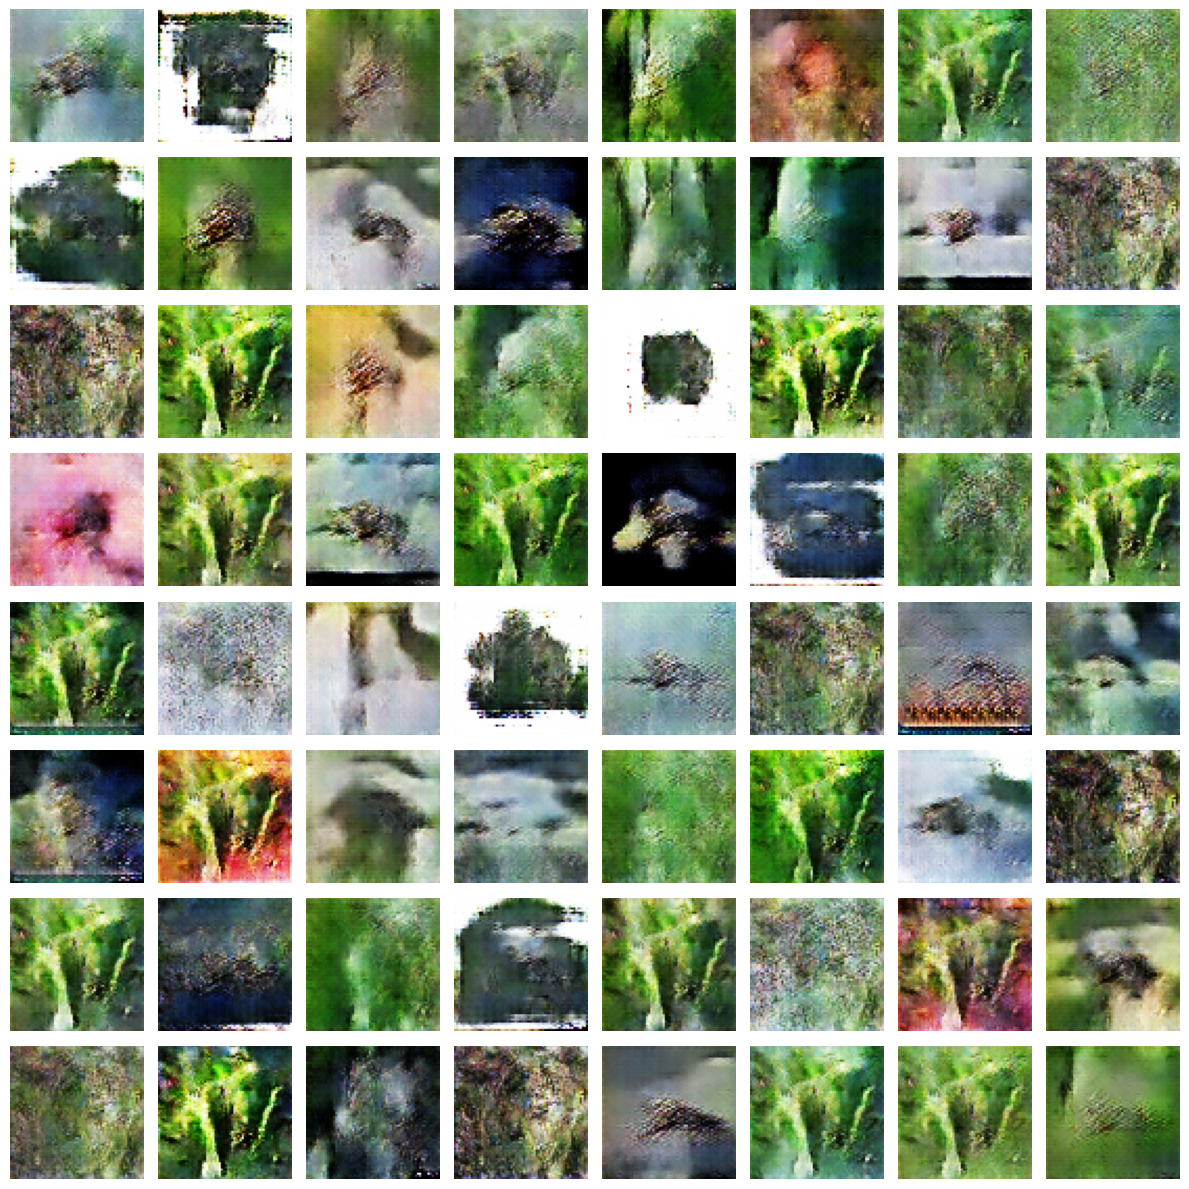

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt

def generate_images(generator, num_images=64, save_dir='generated_images'):

    os.makedirs(save_dir, exist_ok=True)
    

    noise = tf.random.normal([num_images, latent_size])
    generated_images = generator(noise, training=False)
    

    for i, image in enumerate(generated_images):
        filename = os.path.join(save_dir, f'generated_image_{i}.png')
        plt.imsave(filename, (image.numpy() + 1) / 2)
    
    return generated_images


num_images_to_generate = 64


fake_images = generate_images(generator, num_images=num_images_to_generate, save_dir='generated_images')
